In [81]:
import pandas as pd
import scipy
import shap
import numpy as np
import ZCA as zca
import statsmodels.api as sm
import matplotlib as plt

import IPython

from numpy import mean
from numpy import arange
from numpy import std
from numpy import absolute
from pandas import read_csv
import matplotlib.pyplot
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.linear_model import ElasticNet
import seaborn as sns
from ModelDiagnostics import Plot
from sklearn.cluster import DBSCAN
from clustergram import Clustergram
import urbangrammar_graphics as ugg
from sklearn.preprocessing import scale
from scipy import stats
from scipy.special import boxcox, inv_boxcox

import urbangrammar_graphics as ugg
from scipy.stats import f

import pandas as pd
import matplotlib.pyplot as plt  
from matplotlib import colors
from sklearn.preprocessing import StandardScaler

import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from IPython.display import Image


In [82]:
#power = PowerTransformer(method='box-cox')

def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001
    #print("p = {:g}".format(p))    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print(p)
        #print(alpha)
        print("The null hypothesis can be rejected")
        xt, _ = stats.boxcox(x)        
        print(_)
        xt = pd.DataFrame(xt)
        
        return _, pd.DataFrame(xt).set_index(x.index)
    else:
        print("The null hypothesis cannot be rejected")    
        return 1, pd.DataFrame(x)

def inverse_boxcox (data, lambdas):
    return inv_boxcox(data, lambdas.values)
    
def transform_boxcox_l(data, l_):
    transformed = pd.DataFrame()

    for i in range(0,len(data.columns)):
        #print(i)
        if l_.iloc[i].values == 1:
            inner_scale = data.iloc[:,i]            
        else:
            inner_scale = pd.DataFrame(stats.boxcox((data.iloc[:,i]), lmbda=l_.iloc[i].values))
            
        inner_scale.index = data.index
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed

def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    for i in range(0,len(data.columns)):
        l, inner_scale = testNormal(data.iloc[:,i])
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed, transformed_lambdas

def revert_boxcox (data, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data.iloc[:,i]
        else:
            revert = pd.DataFrame(inv_boxcox(data.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data.columns
    return reverted


In [83]:
all_data = pd.read_csv('/mnt/distvol/states.csv')
all_data.index = all_data.iloc[:,0]

transformed, lambdas = transform_boxcox(all_data.iloc[:,1:])

transformed.columns = all_data.iloc[:,1:].columns
all_data.iloc[:,2:].hist()
transformed.hist()
transformed.to_csv("/mnt/distvol/transformed.csv")

reverted = revert_boxcox(transformed,lambdas)


The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
3.808144164451117
The null hypothesis cannot be rejected
The null hypothesis can be rejected
-1.001341730447453
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
0.027108447248549845


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [84]:
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [85]:

#convert to t from s
#t_ = pd.DataFrame(StandardScaler().fit_transform(transformed))
#from scipy.stats import chi
#t_ = (t_/np.sqrt(scipy.stats.chi2.ppf(.5, len(t_)-1)/len(t_)))
#t_.hist()

trf = zca.ZCA().fit(transformed.iloc[:,1:])

X = pd.DataFrame(trf.transform(transformed.iloc[:,1:]))
X.columns=pd.DataFrame(transformed.iloc[:,1:]).columns
X.index = all_data.index

y = pd.DataFrame((transformed.iloc[:,0]-np.mean(transformed.iloc[:,0]))/np.std(transformed.iloc[:,0]))
y.columns=pd.DataFrame(transformed.iloc[:,0]).columns
y.index = all_data.index

#backwards step
max_pvalue = 1
New_Names = X.columns
X_b = X
while (max_pvalue > .05):
        
    model = sm.OLS(y,sm.tools.tools.add_constant(X_b, prepend=True, has_constant='skip'))
    results = model.fit()

    set_ = X_b.columns.tolist()
    
    max_pvalue = max(results.pvalues[1:])
    if (max_pvalue > .05):
        print(max_pvalue)
        max_pname = (results.pvalues[1:]).idxmax(axis=1)
        set_.remove(max_pname)
        New_Names = set_
    
        trf = zca.ZCA().fit(transformed[New_Names])
    
        X_b = pd.DataFrame(trf.transform(transformed[New_Names]))
        X_b.columns=pd.DataFrame(transformed[New_Names]).columns
        X_b.index = transformed.index

print(results.summary())

data = pd.concat([y,X_b],axis=1)
print(data.columns)
data.index = all_data.index
Path="/mnt/distvol"
filename="data"
data.to_csv("/mnt/distvol/data.csv",index=False)


0.9252267413537292
0.7352020565009149
0.596282974973262
0.21070066661079634
0.1345002468353412
                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     74.05
Date:                Mon, 17 May 2021   Prob (F-statistic):           3.28e-19
Time:                        21:43:56   Log-Likelihood:                -20.300
No. Observations:                  50   AIC:                             50.60
Df Residuals:                      45   BIC:                             60.16
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     74.05
Date:                Mon, 17 May 2021   Prob (F-statistic):           3.28e-19
Time:                        21:43:56   Log-Likelihood:                -20.300
No. Observations:                  50   AIC:                             50.60
Df Residuals:                      45   BIC:                             60.16
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.396e-16      0.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
            rstudent unadjusted p-value Bonferroni p
Mississippi 2.377785           0.021827           NA
[0.]


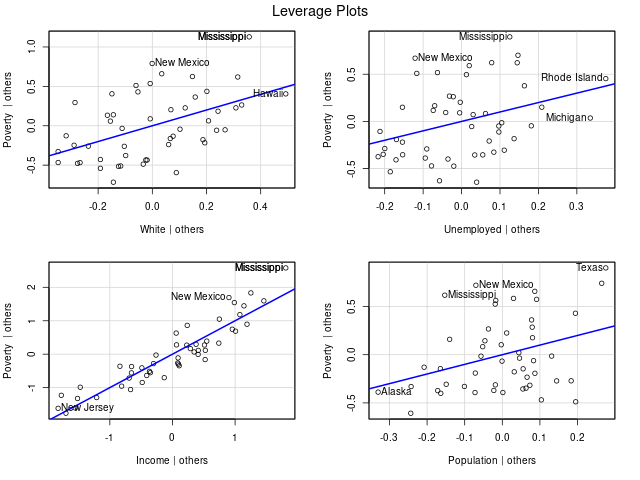

In [86]:
linear_plot = Plot.LinearRegressionResidualPlot(X_b, y)
#linear_plot = LinearRegressionResidualPlot(X_b, y)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

sm.graphics.influence_plot(results)
plt.show()

import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

grdevices = importr('grDevices')

grdevices.png(file="/mnt/distvol/leverage.jpg", width=640, height=480)
ro.r('''
eq <- function(data) {
library(carData,lib.loc = "/mnt/distvol/R-4.0.5/library")
library(car,lib.loc = "/mnt/distvol/R-4.0.5/library")

fit <- lm(data)
print(outlierTest(fit))
leveragePlots(fit)

}
''')
r_eq = ro.globalenv['eq']
p=ro.conversion.rpy2py(r_eq(ro.conversion.py2rpy(data)))
#p = ro.r('eq(1)')            # OUTPUTS TO FILE
print(p)
grdevices.dev_off()
from IPython.display import Image
Image("/mnt/distvol/leverage.jpg")




array([[<AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Population'}>],
       [<AxesSubplot:title={'center':'Poverty'}>,
        <AxesSubplot:title={'center':'Unemployed'}>],
       [<AxesSubplot:title={'center':'White'}>, <AxesSubplot:>]],
      dtype=object)

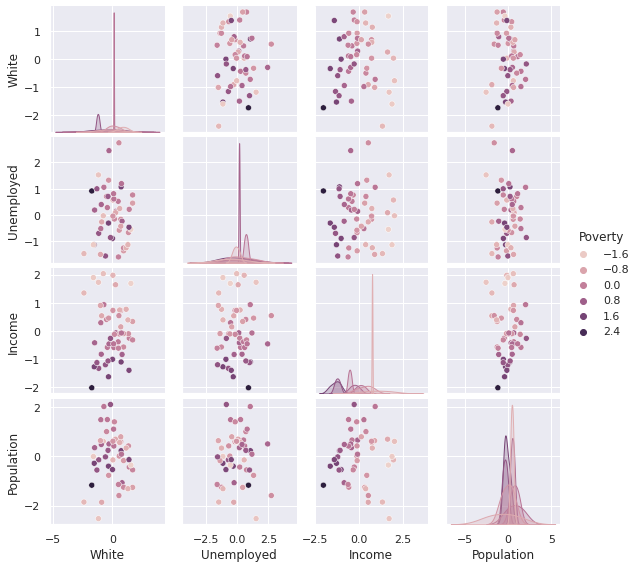

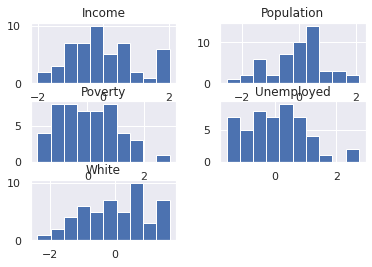

In [87]:
%matplotlib inline

sns.pairplot(pd.concat([y,X_b],axis=1), hue='Poverty', height=2);

pd.concat([y,X_b],axis=1).hist()

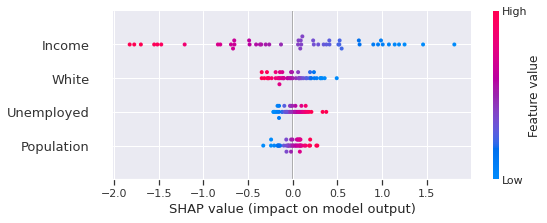

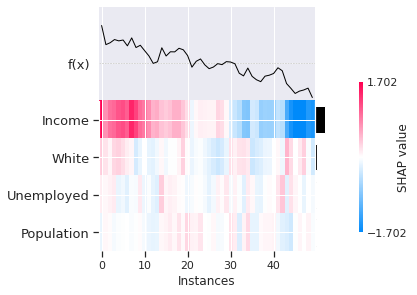

In [88]:

model = sklearn.linear_model.LinearRegression()
model.fit(X_b, y)

shap.initjs()
e = shap.explainers.Linear(model, X_b)

shap_values = e.shap_values(X_b)
shap.summary_plot(shap_values, X_b)
shap.plots.heatmap(e(X_b))

In [89]:
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF

pca = PCA(n_components=0.99, svd_solver='full')
pca.fit(scale(transformed))
#pca.explained_variance_
print(pca.explained_variance_ratio_.cumsum())

X_pca = pd.DataFrame(pca.transform(scale(transformed)))

X_pca.index = all_data.index

scaled_pca_var = (1-(1-pca.explained_variance_ratio_.cumsum()))/sum(1-(1-pca.explained_variance_ratio_.cumsum()))

pca_scaled = pd.DataFrame()
for i in range(0,len(X_pca.columns)):
    #inner_scale = pd.DataFrame(X_pca.iloc[:,i].*scaled_pca_var[i])
    inner_scale = X_pca.iloc[:,i] * pca.explained_variance_ratio_[i]
    #plt.plot(pd.DataFrame(st.norm.ppf(ecdf[i].y)).mul(pca.explained_variance_ratio_[i],axis=0))
    #plt.show()
    pca_scaled = pd.concat([pca_scaled,inner_scale],axis=1)
    
pca_scaled.index = all_data.index


[0.43006205 0.67448932 0.77861908 0.8378841  0.89333174 0.93299362
 0.9642088  0.98085949 0.99530264]


[1] "Minnesota"
[1] 0.002583824
[1] "Colorado"
[1] 0.009032515
[1] "Washington"
[1] 0.01771935
[1] "Connecticut"
[1] 0.006435666
[1] "Massachusetts"
[1] 0.00696968
[1] "New Jersey"
[1] 0.0190019
[1] "Virginia"
[1] 0.009214945
[1] "Hawaii"
[1] 0.1009399
[1] "Maryland"
[1] 0.05662809
[1] "New York"
[1] 0.09681777
[1] "California"
[1] 0.0313794
[1] "Illinois"
[1] 0.1295247
[1] "Pennsylvania"
[1] 0.2319989
[1] "Michigan"
[1] 0.03562603
[1] "Ohio"
[1] 0.09055581
[1] "North Carolina"
[1] 0.007295679
[1] "Tennessee"
[1] 0.002883399
[1] "South Carolina"
[1] 0.01563685
[1] "Louisiana"
[1] 0.02143581
[1] "Alabama"
[1] 0.006031162
[1] "Mississippi"
[1] 0.02109671
[1] "Arkansas"
[1] 0.01233633
[1] "Oklahoma"
[1] 0.01626086
[1] "New Mexico"
[1] 0.03109894
[1] "Arizona"
[1] 0.03176813
[1] "Indiana"
[1] 0.009070839
[1] "Kentucky"
[1] 0.06791258
[1] "West Virginia"
[1] 0.03950839
[1] "Montana"
[1] 0.03913906
[1] "Idaho"
[1] 0.1223339
[1] "South Dakota"
[1] 0.04247455
[1] "Wyoming"
[1] 0.04874336
[1] "

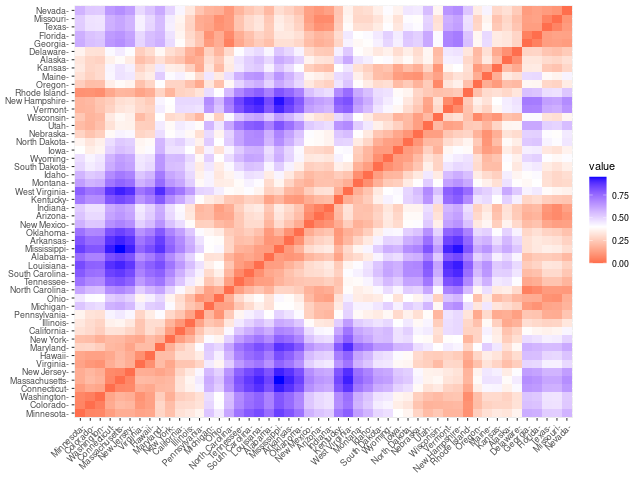

In [90]:

import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

grdevices = importr('grDevices')

grdevices.png(file="/mnt/distvol/rplot.jpg", width=640, height=480)
ro.r('''
eq <- function(values) {
library(cluster)
#library(rgl,lib.loc = "/mnt/distvol/R-4.0.5/library")
#library(pca3d,lib.loc = "/mnt/distvol/R-4.0.5/library")
library(backports,lib.loc = "/mnt/distvol/R-4.0.5/library")
#library(dplyr,lib.loc = "/mnt/distvol/R-4.0.5/library")
library("factoextra",lib.loc = "/mnt/distvol/R-4.0.5/library")
#library("dbscan",lib.loc = "/mnt/distvol/R-4.0.5/library")
#library("mclust",lib.loc = "/mnt/distvol/R-4.0.5/library")
#library("ggpubr",lib.loc = "/mnt/distvol/R-4.0.5/library")
#library("FactoMineR",lib.loc = "/mnt/distvol/R-4.0.5/library")
library("reshape2",lib.loc = "/mnt/distvol/R-4.0.5/library")
#library("data.table",lib.loc = "/mnt/distvol/R-4.0.5/library")
library("NbClust",lib.loc = "/mnt/distvol/R-4.0.5/library")

#data <- read.csv("/mnt/distvol/pca_dist_scaled.csv", row.names=1)
#data2 <- read.csv("/mnt/distvol/states.csv", row.names=1)

data <- values

returnNorm <- function(df)
{
  #print(rownames(df))
  d <- lapply(data[,1:ncol(df)], function(x)
  {
    pnorm(x, mean=0, sd=1, lower.tail=TRUE, log.p =FALSE)
  })
  
  d_ <- data.frame(do.call(cbind, d))
  
  rownames(d_) <- rownames(df)
  #print(rownames(d_))
  return(d_)
   
}

df <- returnNorm(data)
#df2 <- returnNorm(data2[,1:10])

m = (get_dist(df, method = "pearson"))

m = (as.matrix(m))
nm = m

names = rownames(df)
new_names = names

mi = (min(nm[nm>0]))

s = which(( nm == mi), arr.ind=T )

removed = c()

states <- c()

first = new_names[s[1]]

while(length(removed)<49)
{
  states <- c(states, first)
  removed = c(removed,first)
  print(first)

  nm = m[which(names %in% new_names),which(names %in% new_names)]
  second_column = nm[,which(new_names==first)]
  
  column_min = min(second_column[second_column>0])
  print(column_min)
    
  column_min_id = data.frame(which(second_column == column_min))[,1]
  
  column_min_name = new_names[column_min_id]
  
  new_names = names[-which(names %in% removed)]
  
  first = column_min_name
  
}

states <- c(states,rownames(df)[-which(names %in% states)])

keyDF <- data.frame(key=states,weight=1:length(states))

df['States'] = names
#print(df)
merged <- merge(df,keyDF,by.x='States',by.y='key',all.x=T,all.y=F)
res <- merged[order(merged$weight),2:(ncol(df))]
#print(res)
rownames(res) <- states

dist.eucl <- dist(res, method = "euclidean")

#par(mfrow=c(1,2))

#jpeg(file = "myplot%d.jpeg")

#print(df[,1:ncol(df)-1])
nc <- NbClust(data=df[,1:ncol(df)-1], diss = NULL, distance = "euclidean",
        min.nc = 2, max.nc = 15, method = "kmeans")
value = length(unique(nc$Best.partition))
plot(fviz_dist(dist.eucl,show_labels = TRUE, order = FALSE))
#dev.off()

#plot(fviz_dist(dist.eucl,show_labels = TRUE, order = TRUE))
return(list(states,value))

}
''')
r_eq = ro.globalenv['eq']
p=ro.conversion.rpy2py(r_eq(ro.conversion.py2rpy(pca_scaled)))
#p = ro.r('eq(1)')            # OUTPUTS TO FILE
print(p)
grdevices.dev_off()
from IPython.display import Image
Image("/mnt/distvol/rplot.jpg")




In [91]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import QuantileTransformer

cgram = Clustergram(range(1, 9), n_init=1000)
cgram.fit(pca_scaled)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
    pca_weighted=False
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')


K=1 fitted in 3.41874098777771 seconds.
K=2 fitted in 1.5767810344696045 seconds.


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
cgram.silhouette_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
cgram.calinski_harabasz_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

cluster_pca = cgram.labels.iloc[:,(cgram.calinski_harabasz_score()).idxmax(axis=1)-1]



In [ ]:
from itertools import cycle
import matplotlib.pyplot as plt

all_data2 = all_data.iloc[:,1:10]

cluster_pca.index = all_data2.index

pca_scaled['labels'] = pd.DataFrame(cluster_pca)
transformed['labels'] = pd.DataFrame(cluster_pca)
transformed.to_csv("transformed.csv")
pca_scaled.to_csv("pca_dist_scaled.csv")
all_data2['labels'] = pd.DataFrame(cluster_pca)

summary_set2 = all_data2[all_data2['labels']>=-1][all_data2.columns].groupby('labels').mean()
summary_set2["count"] = pd.DataFrame(all_data2[all_data2['labels']>=-1][all_data2.columns].groupby('labels').count())[all_data2.columns[0]]
print(summary_set2)

%matplotlib inline 

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

for i in range(0,(cgram.calinski_harabasz_score()).idxmax(axis=1)):
        fig = plt.figure(figsize=(24,4))  
        group = all_data2.loc[all_data2.index[cluster_pca==i]]
        #groupmean = group.iloc[:,0].mean()        
        print(group.index)
        for j in range(0,len(all_data2.columns)-2):                
            plt.subplot(1,len(all_data2.columns)-1,j+1)
            #plt.subplot(1,2,2)
            
            sns.violinplot(x=group[group.columns[j]],color=next(colors))
            #sns.violinplot(ax=axes[j,0], x=group[group.columns[j]])     
            #print(i,j)

        plt.show()
        
sns.pairplot(all_data2, hue='labels', height=1);
    

        

In [ ]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import sklearn
from sklearn.preprocessing import *
from sklearn import preprocessing
import matplotlib.pyplot as plt

scores = np.zeros((10,2,1))

#truth = [False,True]
#for t in truth:
#    for p in range(0,2):
#        for i in range(0,10):
#            scores[i,p,t] = [i*p*t]
#scores

#True disables

c_box_d = [True]
polys = [2]
i_only_choice = [True]
numRuns = 1

for p in polys:
    
    for ic in i_only_choice:
        
        for cbd in c_box_d:

            scores = []
            for r in range(0,numRuns):            

                # evaluate an elastic net model on the dataset
                tsize = .20
                train, test = train_test_split(all_data.iloc[:,1:], test_size=tsize, shuffle=True)

                #interaction = PolynomialFeatures(degree=p, include_bias=False, interaction_only=False)
                interaction = PolynomialFeatures(degree=p, include_bias=False, interaction_only=ic)

                train_t, lambdas_t = transform_boxcox(train)

                #disabled boxcox
                if cbd:
                    train_t = train

                scaler = preprocessing.StandardScaler().fit(train_t)

                #
                train_s = pd.DataFrame(scaler.transform(train_t))
                train_s.columns = train.columns
                train_s.index = train.index  

                train_t = train_s

                test_t = transform_boxcox_l(test, lambdas_t)

                #disabled boxcox
                if cbd:
                    test_t = test

                test_s = pd.DataFrame(scaler.transform(test_t))
                test_s.columns = test.columns
                test_s.index = test.index

                test_t = test_s

                y_train = pd.DataFrame(train_t.iloc[:,0])

                #exclude y

                X_train = train_t.iloc[:,1:]

                X_inter_train = pd.DataFrame(interaction.fit_transform(X_train), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_t.iloc[:,1:]).columns))

                    #apply ZCA each time a set of factors are removed (i.e. iteratively)
                 #trf = zca.ZCA().fit(X_inter_train)
                  #trf = zca.ZCA().fit(X_train)

                 #X_train = pd.DataFrame(trf.transform(X_inter_train))
                  #X_train = pd.DataFrame(trf.transform(X_train))
                 #X_train.columns=X_inter_train.columns
                  #X_train.columns=X_train.columns
                  #X_train.index = train.index

                #X_inter_alt = X_train.iloc[:, np.array(range(0,len(all_data.iloc[:,2:].columns)))]
                #print(X_inter_alt.head(3))

                y_test = pd.DataFrame(test_t.iloc[:,0])

                X_test = test_t.iloc[:,1:]

                X_inter_test = pd.DataFrame(interaction.fit_transform(X_test), columns=interaction.get_feature_names(input_features=pd.DataFrame(test_t.iloc[:,1:]).columns))

                 #X_test = pd.DataFrame(trf.transform(X_inter_test))
                  #X_test = pd.DataFrame(trf.transform(X_test))

                 #X_test.columns=X_inter_test.columns
                  #X_test.columns=X_test.columns
                  #X_test.index = test.index

                #X_inter_t_alt = X_test.iloc[:, np.array(range(0,len(all_data.iloc[:,2:].columns)))]
                #X_inter_t_alt.head()



                '''
                model = ElasticNet()
                # define model evaluation method
                cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
                # define grid
                grid = dict()
                grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
                grid['l1_ratio'] = arange(0, 1, 0.01)
                # define search
                search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
                # perform the search
                results = search.fit(X_train, y_train)
                # summarize
                print('MAE: %.3f' % results.best_score_)
                print('Config: %s' % results.best_params_)
                '''

                # define model evaluation method
                cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
                # define model
                ratios = arange(0, 1, 0.01)
                alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
                model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, verbose=0)
                # fit model

                 #model.fit(X_train, y_train)
                model.fit(X_inter_train, y_train)
                # summarize chosen configuration
                print('alpha: %f' % model.alpha_)
                print('l1_ratio_: %f' % model.l1_ratio_)

                #prediction
                yhat = model.predict(X_inter_test)

                 #coef = pd.DataFrame(model.coef_).set_index(X_train.columns)
                coef = pd.DataFrame(model.coef_).set_index(X_inter_train.columns)

                a_coef = abs(coef)
                a_coef.sort_values(by=[0],ascending=False,inplace=True)
                a_coef

                 #print(model.score(X_train, y_train, sample_weight=None))
                 #print(model.score(X_test, y_test, sample_weight=None))
                trainScore = model.score(X_inter_train, y_train, sample_weight=None)
                testScore = model.score(X_inter_test, y_test, sample_weight=None)
                print(trainScore)
                print(testScore)
                scores.append(testScore)

                #print(model.score(X, y, sample_weight=None))
                #print(model.coef_)
                model.coef_

            print("# polynomials/interactions: " +str(p))
            print("cox box transform?: " +str(cbd))
            print("disable polynomials: " + str(ic))
            print("mean score: " + str(mean(scores)))
            print(scores)
            #pd.DataFrame(scores).hist
            plt.hist(pd.DataFrame(scores))
            plt.show()
            
        

In [ ]:
#defaults
cbd = True
p = 2
ic = True


In [ ]:
import matplotlib.pyplot as plt
#predicted = pd.DataFrame(yhat*std_+mean_)
predicted = pd.DataFrame(yhat * scaler.scale_[0] + scaler.mean_[0])
if cbd==True:
    if lambdas_t.iloc[0].values==1:
        print("true")
        predicted=predicted
    else:
        predicted = pd.DataFrame(stats.boxcox(predicted.iloc[:,0], lmbda=lambdas_t.iloc[0].values))

predicted.index = y_test.index
predicted.columns = y_test.columns

actual = pd.DataFrame(y_test * scaler.scale_[0] + scaler.mean_[0])
if cbd==True:
    if lambdas_t.iloc[0].values==1:
        print("true")
        actual=actual
    else:
        actual = pd.DataFrame(stats.boxcox(actual.iloc[:,0], lmbda=lambdas_t.iloc[0].values))

actual.index = y_test.index
plt.scatter(predicted, actual)

plt.show()

plt.hist(predicted-actual, bins='auto')  # arguments are passed to np.histogram

rmse = mean_squared_error(actual, predicted, squared=True)
mape = MAPE(actual, predicted)

print("rmse",rmse)
print("mape",mape)

In [ ]:
%matplotlib inline
shap.initjs()


# explain predictions of the model on four images
e = shap.LinearExplainer(model, X_inter_train)
#explainer = shap.KernelExplainer(model, X_train, link="logit")
print(y_test.columns)
shap_values = e.shap_values(X_inter_test)
shap.summary_plot(shap_values, X_inter_test)
explainer = shap.Explainer(model, X_inter_train)
shap.plots.heatmap(explainer(X_inter_test))

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_inter_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

#pre_list = feature_importance[feature_importance["feature_importance_vals"]>.01]["col_name"].values.tolist()
pre_list = feature_importance[feature_importance["feature_importance_vals"]>0]["col_name"].values.tolist()
pre_list.insert(0,all_data.columns[1])

In [ ]:
#Model as defined by elastic net

train = all_data.iloc[:,1:]

interaction = PolynomialFeatures(degree=p, include_bias=False, interaction_only=ic)

train_t, lambdas_t = transform_boxcox(train)

#disabled boxcox
if cbd:
    train_t = train

scaler_y = preprocessing.StandardScaler().fit(np.array(train_t.iloc[:,0]).reshape(-1, 1))

scaler_x = preprocessing.StandardScaler().fit(train_t.iloc[:,1:])

y_train = pd.DataFrame(scaler_y.transform(np.array(train_t.iloc[:,0]).reshape(-1, 1)))
y_train.index = train.index
y_train.columns = pd.DataFrame(train.iloc[:,0]).columns
                       
X_train = pd.DataFrame(scaler_x.transform(train_t.iloc[:,1:]))

X_inter_train = pd.DataFrame(interaction.fit_transform(X_train), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_t.iloc[:,1:]).columns))
X_inter_train = X_inter_train[pre_list[1:]]
X_inter_train.index = X_train.index

scaler_x_i = zca.ZCA().fit(X_inter_train)

X_inter_train_i = pd.DataFrame(scaler_x_i.transform(X_inter_train))
X_inter_train_i.columns = X_inter_train.columns
X_inter_train_i.index = train.index

vetted_data_set=pd.concat([y_train, X_inter_train_i[pre_list[1:]]],axis=1)

model = sm.OLS(y_train,sm.tools.tools.add_constant(vetted_data_set.iloc[:,1:], prepend=True, has_constant='skip'))        
results = model.fit()



In [ ]:
linear_plot = Plot.LinearRegressionResidualPlot(vetted_data_set.iloc[:,1:], y_train)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

sm.graphics.influence_plot(results)
plt.show()

if False:
    grdevices = importr('grDevices')

    grdevices.png(file="/mnt/distvol/leverage2.jpg", width=640, height=480)
    ro.r('''
    eq <- function(data) {
    library(carData,lib.loc = "/mnt/distvol/R-4.0.5/library")
    library(car,lib.loc = "/mnt/distvol/R-4.0.5/library")

    fit <- lm(data)
    print(outlierTest(fit))
    leveragePlots(fit)

    }
    ''')
    r_eq = ro.globalenv['eq']
    p=ro.conversion.rpy2py(r_eq(ro.conversion.py2rpy(pd.concat([y_train,vetted_data_set.iloc[:,1:]],axis=1))))
    #p = ro.r('eq(1)')            # OUTPUTS TO FILE
    #print(p)
    grdevices.dev_off()

    Image("/mnt/distvol/leverage2.jpg")



In [ ]:
#Model as defined by elastic net with backwards step applied

train = all_data.iloc[:,1:]

interaction = PolynomialFeatures(degree=p, include_bias=False, interaction_only=ic)

train_t, lambdas_t = transform_boxcox(train)

#disabled boxcox
if cbd:
    train_t = train

scaler_y = preprocessing.StandardScaler().fit(np.array(train_t.iloc[:,0]).reshape(-1, 1))

 #scaler_x = zca.ZCA().fit(train_t.iloc[:,1:])
scaler_x = preprocessing.StandardScaler().fit(train_t.iloc[:,1:])

y_train = pd.DataFrame(scaler_y.transform(np.array(train_t.iloc[:,0]).reshape(-1, 1)))
y_train.index = train.index
y_train.columns = pd.DataFrame(train.iloc[:,0]).columns
                       
X_train = pd.DataFrame(scaler_x.transform(train_t.iloc[:,1:]))

X_inter_train = pd.DataFrame(interaction.fit_transform(X_train), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_t.iloc[:,1:]).columns))
X_inter_train.index = X_train.index
X_inter_train = X_inter_train[pre_list[1:]]

#vetted_data_set=pd.concat([y_train, X_inter_train[pre_list[1:]]],axis=1)

#backwards step
'''
#Note: due to order of operations
CoxBox Transform
ZCA Whitening (if you zca whiten, then remove an interaction that had a variable as it's base...)
Interactions.

I cannot easily remove irrelevant terms and then re-ZCA whiten.  So I've left the ZCA whitening in place
'''
max_pvalue = 1
New_Names = X_inter_train.columns
X_b = X_inter_train
while (max_pvalue > .05):
        
    trf = zca.ZCA().fit(X_b)
        
    X_b_z = pd.DataFrame(trf.transform(X_b))
    X_b_z.columns=pd.DataFrame(X_b).columns
    X_b_z.index = train.index

    model = sm.OLS(y_train,sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip'))        
    results = model.fit()

    set_ = X_b.columns.tolist()
    
    max_pvalue = max(results.pvalues[1:])
    if (max_pvalue > .05):
        print(max_pvalue)
        max_pname = (results.pvalues[1:]).idxmax(axis=1)
        set_.remove(max_pname)
        New_Names = set_
    
        X_b = X_inter_train[New_Names]
        X_b.index = train.index


In [ ]:

linear_plot = Plot.LinearRegressionResidualPlot(X_b_z, y_train)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

sm.graphics.influence_plot(results)
plt.show()

if False:
    grdevices = importr('grDevices')

    grdevices.png(file="/mnt/distvol/leverage3.jpg", width=640, height=480)
    ro.r('''
    eq <- function(data) {
    library(carData,lib.loc = "/mnt/distvol/R-4.0.5/library")
    library(car,lib.loc = "/mnt/distvol/R-4.0.5/library")

    fit <- lm(data)
    print(outlierTest(fit))
    leveragePlots(fit)

    }
    ''')
    r_eq = ro.globalenv['eq']
    p=ro.conversion.rpy2py(r_eq(ro.conversion.py2rpy(pd.concat([y_train,X_b_z],axis=1))))
    #p = ro.r('eq(1)')            # OUTPUTS TO FILE
    print(p)
    grdevices.dev_off()

    Image("/mnt/distvol/leverage3.jpg")




In [ ]:
pca = PCA(n_components=0.99, svd_solver='full')
pca.fit(X_b)
#pca.explained_variance_
print(pca.explained_variance_ratio_.cumsum())

X_pca = pd.DataFrame(pca.transform(X_b))

X_pca.index = all_data.index

scaled_pca_var = (1-(1-pca.explained_variance_ratio_.cumsum()))/sum(1-(1-pca.explained_variance_ratio_.cumsum()))
'''
pca_scaled = pd.DataFrame()
for i in range(0,len(X_pca.columns)):
    #inner_scale = pd.DataFrame(X_pca.iloc[:,i].*scaled_pca_var[i])
    inner_scale = X_pca.iloc[:,i] * pca.explained_variance_ratio_[i]
    #plt.plot(pd.DataFrame(st.norm.ppf(ecdf[i].y)).mul(pca.explained_variance_ratio_[i],axis=0))
    #plt.show()
    pca_scaled = pd.concat([pca_scaled,inner_scale],axis=1)
    
pca_scaled.index = all_data.index
'''

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

sns.set(style = "darkgrid")

pca_set = pd.concat([y_train,X_pca],axis=1)
#from earlier pca analysis
pca_set['labels'] = pca_scaled['labels']

fig = plt.figure(figsize=[16,16])
ax = fig.add_subplot(111, projection = '3d')

x = pca_set.iloc[:,1]
y = pca_set.iloc[:,2]
z = pca_set.iloc[:,3]

m = np.array([x,y,z])
scatter = ax.scatter(x,y,z, c=pca_set.iloc[:,0], cmap="RdYlGn", s=(pca_set['labels']+2)*40, edgecolors="black")

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)

#legend2 = ax.legend(*scatter.legend_elements(prop="sizes", alpha=0.6),loc="upper left", title="clusters")

legend2 = ax.legend(handles, range(0,len(labels)), loc="upper right", title="clusters")
#ax.legend()
ax.add_artist(legend2)
    
states = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
for i in range(len(m[0]-1)): #plot each point + it's index as text above 
    #ax.scatter(m[0,i],m[1,i],m[2,i], marker=set_.iloc[i]['clusters']+2, s=100, color='k') 
    ax.text(m[0,i],m[1,i],m[2,i],  '%s' % (str(states[i])), size=10, zorder=1,  color='k') 
   
#legend1 = ax.legend(*scatter.legend_elements(num=5),loc="upper left", title="Ranking")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Poverty")
ax.add_artist(legend1)


#kw = dict(prop="sizes", num=5, color=scatter.cmap(0.7), fmt="$ {x:.2f}",func=lambda s: np.sqrt(s/.3)/3)

#legend2 = ax.legend(*scatter.legend_elements(**kw),loc="lower right", title="Price")

ax.legend()
ax.set_xlabel(pca_set.columns[1])
ax.set_ylabel(pca_set.columns[2])
ax.set_zlabel(pca_set.columns[3])
plt.show()


In [ ]:

if False:
    %matplotlib inline
    sns.set(style='whitegrid')

    #iris = sns.load_dataset(pd.concat([y,X_b],axis=1))
    #g = sns.pairplot(pca_set, hue="labels")
    #g = sns.pairplot(pd.concat([y_train, X_b_z, pca_scaled['labels']],axis=1), hue = 'labels')
    g = sns.pairplot(pd.concat([y_train, X_b_z, pca_scaled['labels']],axis=1), hue = 'Poverty')
    g.fig.suptitle("Data", y=1.01)

In [ ]:
from statsmodels.graphics.gofplots import ProbPlot
import matplotlib.pyplot as plt

residuals_normalized = lm.get_influence().resid_studentized_external
cooks = lm.get_influence().cooks_distance[0]
cooks = np.round(f.pdf(cooks,len(lm.tvalues)+1, len(lm.fittedvalues)-len(lm.tvalues)-1),2)

res_std = lm.get_influence().resid_std

leverage = lm.get_influence().hat_matrix_diag

plt.hist(pd.DataFrame(leverage))
plt.show()

plt.hist(pd.DataFrame(cooks))
plt.show()

plt.hist(pd.DataFrame(residuals_normalized))
plt.show()


testNormal(residuals_normalized)

w = res_std
x = cooks
y = leverage
z = residuals_normalized

fitted_y = lm.fittedvalues

labels_ = fitted_y.index

outlier_check = pd.concat([pd.DataFrame(x),pd.DataFrame(y),pd.DataFrame(z),pd.DataFrame(w)],axis=1).set_index(labels_)

outlier_check.columns =  ['cooks', 'leverage', 'tsres', 'sres']

qq = ProbPlot(residuals_normalized)

c_thresh = .1
l_thresh = (2*(len(lm.tvalues)-1)/len(lm.fittedvalues))
s_thresh = max(qq.theoretical_quantiles)

print("Outlier threshold's")
print("Cooks distance: > .1+")
print("Leverage: > " + str(l_thresh) + " to " + str(3 * (len(lm.tvalues)-1)/len(fitted_y)))
print("Studentized residuals: > " + str(s_thresh))
print()

flag = []

for i in range(0,len(outlier_check)):
    if( (outlier_check.iloc[i][0] >= c_thresh) or (outlier_check.iloc[i][1] >= l_thresh) or (abs(outlier_check.iloc[i][2]) >= s_thresh) ):
        flag.append(True)
    else:
        flag.append(False)

outlier_check = pd.concat([outlier_check,pd.DataFrame(flag).set_index(labels_)],axis=1)

outlier_check.columns =  ['cooks', 'leverage', 'tsres', 'sres', 'flagged']

search = outlier_check[outlier_check['flagged']==1].index.to_list()

rows = []

for i in search:
    v = outlier_check.index.to_list().index(i)
    rows.append(v)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt  
from matplotlib import colors
A = pd.DataFrame(np.random.randn(6, 3), columns=['a', 'b', 'c']) 
B = pd.DataFrame(np.random.randn(6, 3), columns=['a', 'b', 'c'])
def b_g(s, cmap='PuBu', low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    rng = a.max() - a.min()
    norm = colors.Normalize(a.min() - (rng * low),
                        a.max() + (rng * high))
    normed = norm(a.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

B.style.apply(b_g,cmap='PuBu')

In [232]:
trf_ = zca.ZCA().fit(transformed)

X_ = pd.DataFrame(trf_.transform(transformed))
X_.columns=pd.DataFrame(transformed).columns
X_.index = all_data.index

x_ = StandardScaler(with_mean=True, with_std=True).fit_transform(X_)
t_ = pd.DataFrame(x_).set_index(all_data.index)
t_.columns = all_data.iloc[:,1:].columns
Z_ = pd.concat([t_,outlier_check,all_data2['labels']],axis=1)
#.sort_values(by=['labels'], ascending=False)
Z_['flagged'] = np.where(outlier_check['flagged'] == True, 1, 0)
Z_ = Z_*-1
Z_['Income'] = Z_['Income']*-1
Z_['University'] = Z_['University']*-1
Z_['Doctors'] = Z_['Doctors']*-1
Z_['White'] = Z_['White']*-1

A = pd.concat([X_,outlier_check,all_data2['labels']],axis=1)
#.sort_values(by=['labels'], ascending=False)
A['flagged'] = np.where(outlier_check['flagged'] == True, 1, 0)
A = A*-1
A['Income'] = A['Income']*-1
A['University'] = A['University']*-1
A['Doctors'] = A['Doctors']*-1
A['White'] = A['White']*-1

C_ = Z_.copy()
for i in transformed.columns:
    C_[i]= (Z_[i]-A[i]).copy()

B = pd.concat([all_data.iloc[:,1:],outlier_check,all_data2['labels']],axis=1)
#.sort_values(by=['labels'], ascending=False)
B['flagged'] = np.where(outlier_check['flagged'] == True, 1, 0)



Poverty


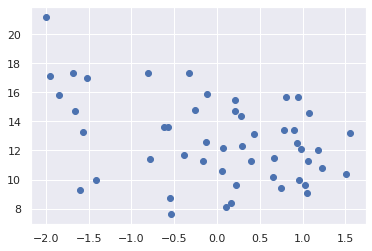

Infant Mort


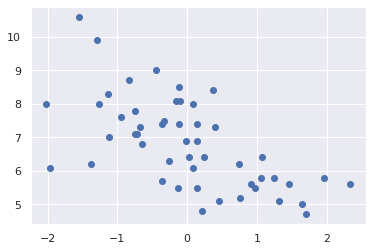

White


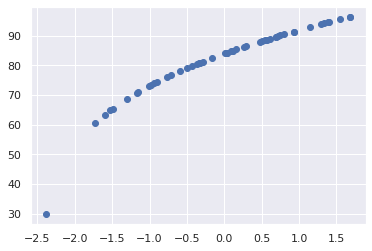

Crime


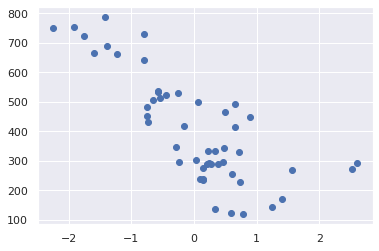

Doctors


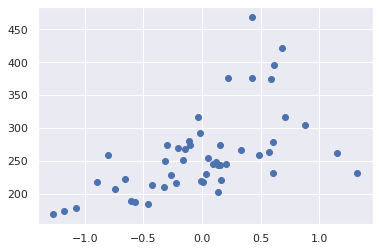

Traf Deaths


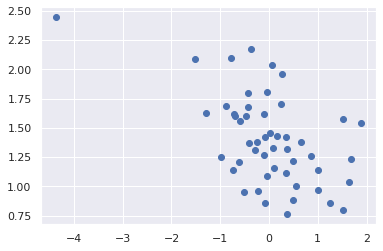

University


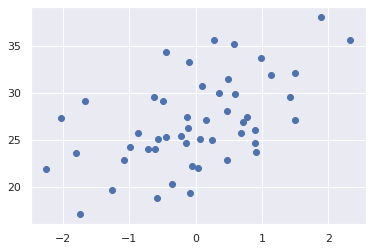

Unemployed


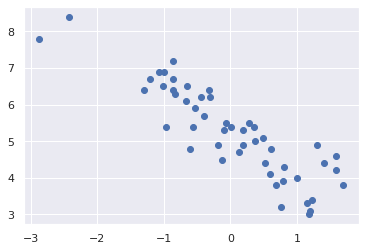

Income


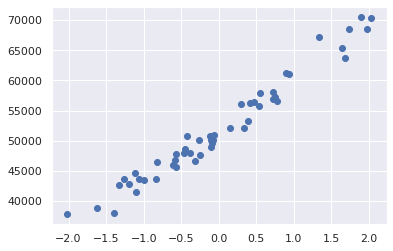

Population


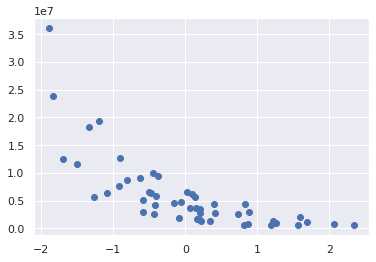

cooks


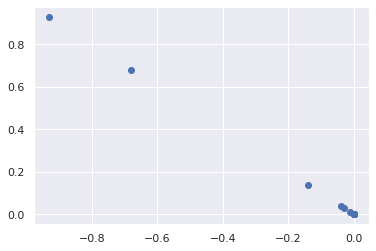

leverage


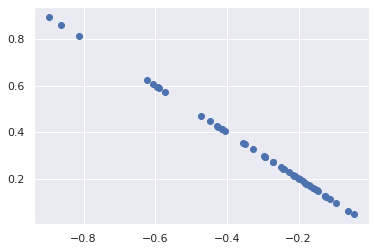

tsres


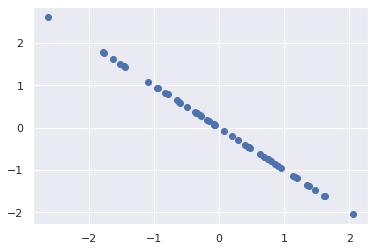

sres


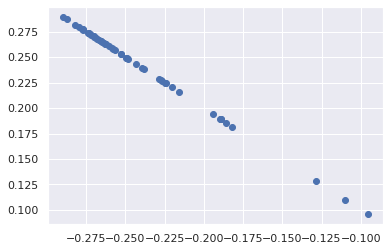

flagged


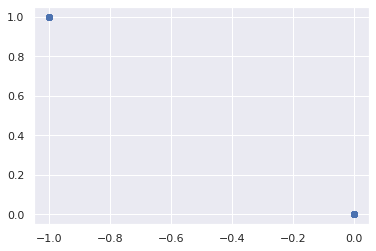

labels


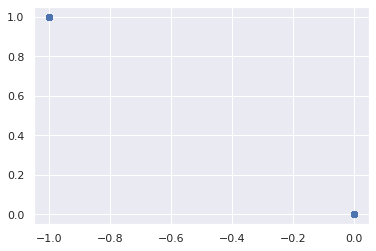

In [233]:
for i in A.columns:
    print(i)
    plt.scatter(A[i].values,B[i].values)
    plt.show()

In [234]:
import dataframe_image as dfi
import imgkit

def b_g(s, cmap='PuBu', low=0, high=0, frame=None):
    # Pass the columns from Dataframe A 
    a = frame.loc[:,s.name].copy()
    rng = a.max() - a.min()
    norm = colors.Normalize(a.min() - (rng * low),
                        a.max() + (rng * high))
    normed = norm(a.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

for i in ['A','C_','Z_']:
    
    if i == 'A':
        frame = A
    if i == 'C_':
        frame = C_
    if i == 'Z_':
        frame = Z_        
    
    df = B.style.apply(b_g,cmap='RdYlGn',frame=frame)
    html = df.render()

    imgkit.from_string(html, str(i) + 'styled_table.png')
#print(sys.path)


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
